## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [1]:
!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 276kB 1.7MB/s ta 0:00:01


Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise in two batches, from 0 to 20 with std equals to 4, and from 20 to 40 with std 1. This is what we eant to predict as the uncertainty of the predictions based on the noise of the input data.

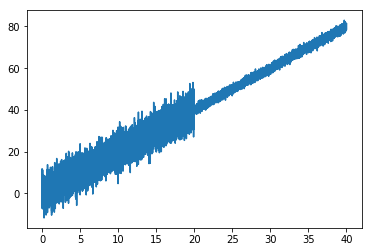

In [2]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
delta = np.random.normal(0, 4, x.size)
y = 2*x + delta
x2 = np.linspace(20, 40, 10000)
delta2 = np.random.normal(0, 1, x2.size)
y2 = 2*x2 + delta2
x = np.append(x, x2)
y = np.append(y, y2)
plt.plot(x,y)
plt.show()

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [3]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma) + epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

def aleatoric_uncertainty(y_true, y_pred):
    sigma = y_pred[:, 1]
    return K.max(K.log(K.square(sigma)), axis=-1)

First we try a model without calculating the sigma and plot the results to see that the model is predicting the right values.

Epoch 1/20
20000/20000 [==============================] - 0s - loss: 5179.0589 - mean_squared_error: 5179.0589     
Epoch 2/20
20000/20000 [==============================] - 0s - loss: 4687.3831 - mean_squared_error: 4687.3831     
Epoch 3/20
20000/20000 [==============================] - 0s - loss: 4297.5010 - mean_squared_error: 4297.5010     
Epoch 4/20
20000/20000 [==============================] - 0s - loss: 3941.5848 - mean_squared_error: 3941.5848     
Epoch 5/20
20000/20000 [==============================] - 0s - loss: 3611.6519 - mean_squared_error: 3611.6519     
Epoch 6/20
20000/20000 [==============================] - 0s - loss: 3304.2468 - mean_squared_error: 3304.2468     
Epoch 7/20
20000/20000 [==============================] - 0s - loss: 3017.2819 - mean_squared_error: 3017.2819     
Epoch 8/20
20000/20000 [==============================] - 0s - loss: 2749.2644 - mean_squared_error: 2749.2644     
Epoch 9/20
20000/20000 [==============================] - 0s - loss: 249

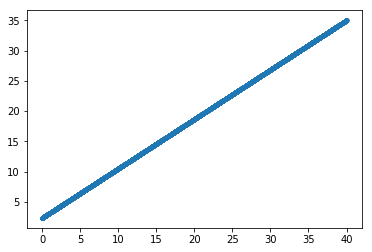

In [5]:
raw_inputs = Input(shape=(1,))
raw_preds = Dense(1, activation='linear', name="preds")(raw_inputs)

rawmodel = Model(inputs=raw_inputs,outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit(x, y, batch_size=128, epochs=40, shuffle=False)
x_raw_pred = np.array([1,2,3,4,5,6,7,8,9,10,15,20])
raw_result = rawmodel.predict(x)
plt.plot(x, raw_result[:,0],'.')
plt.show()

Then we try a model where the sigma is the result of a combination of 3 layers.

In [6]:
inputs = Input(shape=(1,))
sigma = Dense(10, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(inputs)
sigma2 = Dense(5, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma)
sigma3 = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma2)
preds = Dense(1, activation='linear', name="preds")(inputs)
aleatoric_output = concatenate([preds, sigma3])
sgd = SGD(lr=0.1)
adam = Adam(lr=0.001)
rms = RMSprop(lr=0.001)
nadam = Nadam(lr=0.001)
model = Model(inputs=inputs,outputs=aleatoric_output)
model.compile(optimizer=nadam, loss=aleatoric_loss, metrics=[aleatoric_rms, aleatoric_uncertainty])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
sigma (Dense)                    (None, 10)            20          input_2[0][0]                    
____________________________________________________________________________________________________
sigma2 (Dense)                   (None, 5)             55          sigma[0][0]                      
____________________________________________________________________________________________________
preds (Dense)                    (None, 1)             2           input_2[0][0]                    
___________________________________________________________________________________________

In [7]:
model.fit(x, np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=300, shuffle=False)

Epoch 1/300
20000/20000 [==============================] - 0s - loss: 259014.6016 - aleatoric_rms: 5897.5063 - aleatoric_uncertainty: -3.2152     
Epoch 2/300
20000/20000 [==============================] - 0s - loss: 8142.0164 - aleatoric_rms: 5836.2514 - aleatoric_uncertainty: -1.1184     
Epoch 3/300
20000/20000 [==============================] - 0s - loss: 4163.6180 - aleatoric_rms: 5797.2623 - aleatoric_uncertainty: -0.4594     
Epoch 4/300
20000/20000 [==============================] - 0s - loss: 479.8268 - aleatoric_rms: 5783.2004 - aleatoric_uncertainty: 1.9063     
Epoch 5/300
20000/20000 [==============================] - 0s - loss: 126.6108 - aleatoric_rms: 5781.2114 - aleatoric_uncertainty: 3.0525     
Epoch 6/300
20000/20000 [==============================] - 0s - loss: 82.4174 - aleatoric_rms: 5779.7987 - aleatoric_uncertainty: 3.4998     
Epoch 7/300
20000/20000 [==============================] - 0s - loss: 61.5761 - aleatoric_rms: 5778.5771 - aleatoric_uncertainty: 3.811

20000/20000 [==============================] - 0s - loss: 8.7808 - aleatoric_rms: 5312.3767 - aleatoric_uncertainty: 7.7993     
Epoch 59/300
20000/20000 [==============================] - 0s - loss: 8.7686 - aleatoric_rms: 5242.2154 - aleatoric_uncertainty: 7.7873     
Epoch 60/300
20000/20000 [==============================] - 0s - loss: 8.7541 - aleatoric_rms: 5160.3063 - aleatoric_uncertainty: 7.7731     
Epoch 61/300
20000/20000 [==============================] - 0s - loss: 8.7369 - aleatoric_rms: 5064.7253 - aleatoric_uncertainty: 7.7563     
Epoch 62/300
20000/20000 [==============================] - 0s - loss: 8.7164 - aleatoric_rms: 4953.2560 - aleatoric_uncertainty: 7.7362     
Epoch 63/300
20000/20000 [==============================] - 0s - loss: 8.6921 - aleatoric_rms: 4823.3715 - aleatoric_uncertainty: 7.7123     
Epoch 64/300
20000/20000 [==============================] - 0s - loss: 8.6629 - aleatoric_rms: 4672.1999 - aleatoric_uncertainty: 7.6836     
Epoch 65/300
20000/

20000/20000 [==============================] - 0s - loss: 2.4588 - aleatoric_rms: 8.5521 - aleatoric_uncertainty: 1.4703     
Epoch 117/300
20000/20000 [==============================] - 0s - loss: 2.4593 - aleatoric_rms: 8.5519 - aleatoric_uncertainty: 1.4709     
Epoch 118/300
20000/20000 [==============================] - 0s - loss: 2.4597 - aleatoric_rms: 8.5517 - aleatoric_uncertainty: 1.4723     
Epoch 119/300
20000/20000 [==============================] - 0s - loss: 2.4599 - aleatoric_rms: 8.5515 - aleatoric_uncertainty: 1.4722     
Epoch 120/300
20000/20000 [==============================] - 0s - loss: 2.4605 - aleatoric_rms: 8.5513 - aleatoric_uncertainty: 1.4701     
Epoch 121/300
20000/20000 [==============================] - 0s - loss: 2.4612 - aleatoric_rms: 8.5512 - aleatoric_uncertainty: 1.4723     
Epoch 122/300
20000/20000 [==============================] - 0s - loss: 2.4618 - aleatoric_rms: 8.5511 - aleatoric_uncertainty: 1.4727     
Epoch 123/300
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4496 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4415     
Epoch 175/300
20000/20000 [==============================] - 0s - loss: 2.4511 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4453     
Epoch 176/300
20000/20000 [==============================] - 0s - loss: 2.4448 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4356     
Epoch 177/300
20000/20000 [==============================] - 0s - loss: 2.4511 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4447     
Epoch 178/300
20000/20000 [==============================] - 0s - loss: 2.4498 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4423     
Epoch 179/300
20000/20000 [==============================] - 0s - loss: 2.4508 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4455     
Epoch 180/300
20000/20000 [==============================] - 0s - loss: 2.4518 - aleatoric_rms: 8.5504 - aleatoric_uncertainty: 1.4459     
Epoch 181/300
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4249 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4241     
Epoch 233/300
20000/20000 [==============================] - 0s - loss: 2.4248 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4240     
Epoch 234/300
20000/20000 [==============================] - 0s - loss: 2.4247 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4242     
Epoch 235/300
20000/20000 [==============================] - 0s - loss: 2.4245 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4238     
Epoch 236/300
20000/20000 [==============================] - 0s - loss: 2.4240 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4233     
Epoch 237/300
20000/20000 [==============================] - 0s - loss: 2.4245 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4240     
Epoch 238/300
20000/20000 [==============================] - 0s - loss: 2.4243 - aleatoric_rms: 8.5505 - aleatoric_uncertainty: 1.4237     
Epoch 239/300
20000/20000 [=======

20000/20000 [==============================] - 0s - loss: 2.4213 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4221     
Epoch 291/300
20000/20000 [==============================] - 0s - loss: 2.4213 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4221     
Epoch 292/300
20000/20000 [==============================] - 0s - loss: 2.4212 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4220     
Epoch 293/300
20000/20000 [==============================] - 0s - loss: 2.4211 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4220     
Epoch 294/300
20000/20000 [==============================] - 0s - loss: 2.4210 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4220     
Epoch 295/300
20000/20000 [==============================] - 0s - loss: 2.4211 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4219     
Epoch 296/300
20000/20000 [==============================] - 0s - loss: 2.4209 - aleatoric_rms: 8.5506 - aleatoric_uncertainty: 1.4219     
Epoch 297/300
20000/20000 [=======

Here we can see that predictions are still right and the sigmas obtained describe perfectly the variance of the noise introduced in the input data

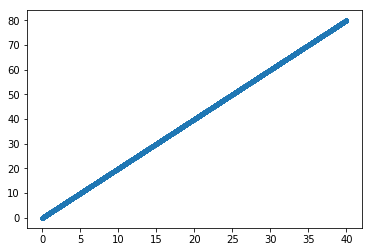

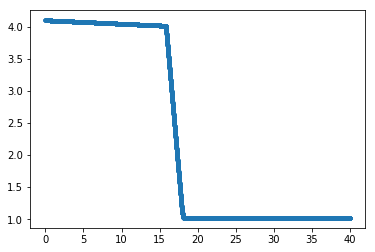

In [8]:
result = model.predict(x)
plt.plot(x, result[:,0],'.')
plt.show()
plt.plot(x, result[:,1],'.')
plt.show()
#result